# ARFS - Customizing GrootCV

GrootCV allows users to customize certain parameters when using the lightGBM algorithm in Python. However, it's essential to be aware that some of these parameters will be automatically adjusted by the algorithm itself. Specifically, the overridden parameters are objective, verbose, is_balanced, and n_iterations.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arfs
from arfs.feature_selection import GrootCV
from arfs.utils import load_data
from arfs.benchmark import highlight_tick

rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import os
import multiprocessing


def get_physical_cores():
    if os.name == "posix":  # For Unix-based systems (e.g., Linux, macOS)
        try:
            return os.sysconf("SC_NPROCESSORS_ONLN")
        except ValueError:
            pass
    elif os.name == "nt":  # For Windows
        try:
            return int(os.environ["NUMBER_OF_PROCESSORS"])
        except (ValueError, KeyError):
            pass
    return multiprocessing.cpu_count()


num_physical_cores = get_physical_cores()
print(f"Number of physical cores: {num_physical_cores}")

Number of physical cores: 4


In [3]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 2.0.5


In [4]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target

In [5]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,random_cat_2,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,0,cat_3517,Platist,7.080332
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,0,cat_2397,MarkZ,5.245384
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,0,cat_3735,Dracula,6.375795
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,0,cat_2870,Bejita,6.725118
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,4,cat_1160,Variance,7.867781


## Number of processes

For optimal performance on CPUs, set the `n_jobs` parameter to match the number of **physical** cores available on your machine. Keep in mind that using `n_jobs=0` will use the default number of threads in OpenMP, and running multiple processes might not always yield faster results due to the overhead involved in initiating those processes.

In [7]:
for n_jobs in range(num_physical_cores):
    start_time = time.time()
    feat_selector = GrootCV(
        objective="rmse",
        cutoff=1,
        n_folds=5,
        n_iter=5,
        silent=True,
        fastshap=False,
        n_jobs=n_jobs,
    )
    feat_selector.fit(X, y, sample_weight=None)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"n_jobs = {n_jobs}, Execution time: {execution_time:.3f} seconds")

invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast


Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

n_jobs = 0, Execution time: 9.602 seconds


Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

n_jobs = 1, Execution time: 8.959 seconds


Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

n_jobs = 2, Execution time: 7.147 seconds


Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

n_jobs = 3, Execution time: 9.987 seconds


## Regularization

By default, GrootCV is using crossvalidation and early-stopping to prevent overfitting and to ensure the robustness of the feature selection. However, if you want to prevent overfitting even more, you can use the dedicated `lightgbm` parameters such as `min_data_in_leaf`.

Let's illustrate:
 - less regularization than default
 - default regularization (`{"min_data_in_leaf": 20}`)
 - larger regularization

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 2 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'NOX', 'CRIM', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'random_num2', 'ZN', 'CHAS']


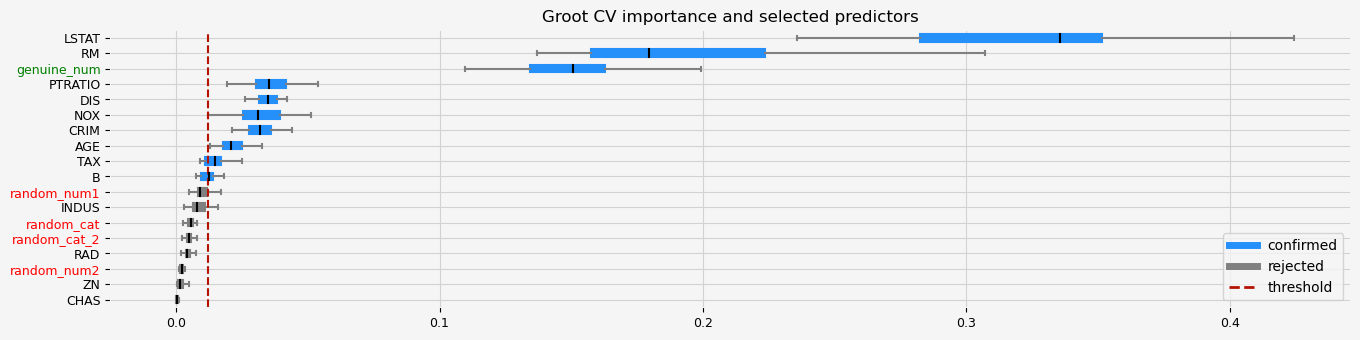

In [8]:
# GrootCV with less regularization
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"min_data_in_leaf": 10},
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 2 2 1 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'PTRATIO', 'DIS', 'NOX', 'CRIM', 'AGE', 'TAX', 'B', 'random_num1', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'ZN', 'random_num2', 'CHAS']


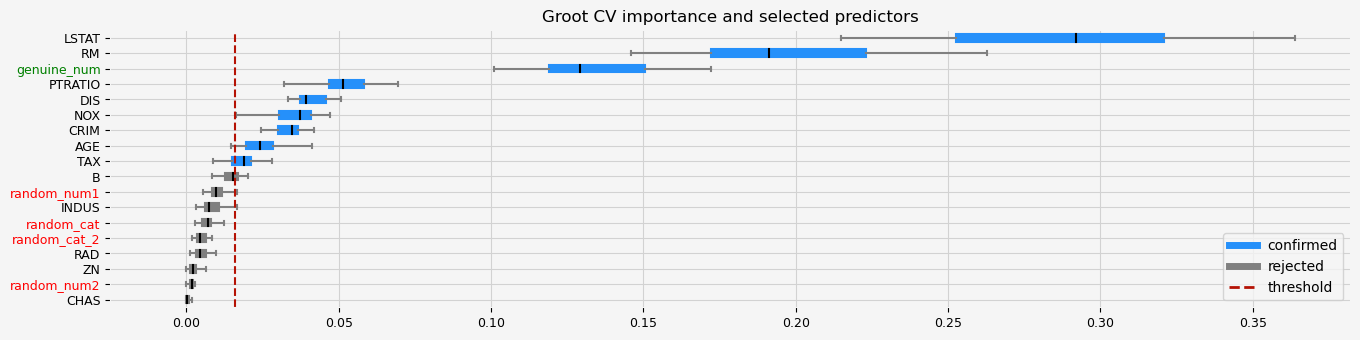

In [9]:
# GrootCV with default regularization
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params=None,
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['CRIM' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [2 1 1 1 1 2 1 2 1 2 2 1 2 1 1 1 1 2]
The naive ranking: ['LSTAT', 'genuine_num', 'RM', 'PTRATIO', 'TAX', 'CRIM', 'DIS', 'B', 'random_num1', 'AGE', 'NOX', 'random_cat', 'RAD', 'random_num2', 'random_cat_2', 'INDUS', 'ZN', 'CHAS']


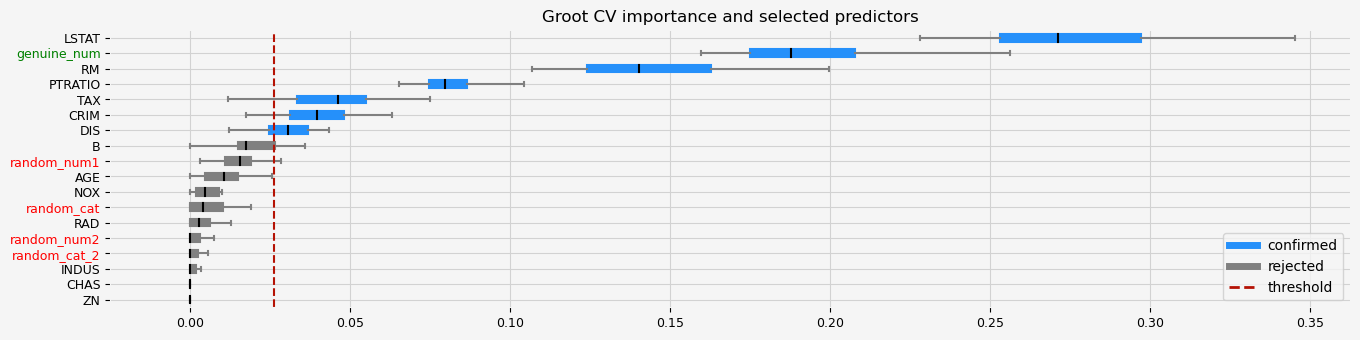

In [10]:
# GrootCV with larger regularization
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
    lgbm_params={"min_data_in_leaf": 100},
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()